In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                    download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                    download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


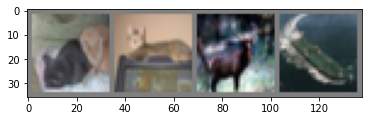

cat   cat   deer  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(labels) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN 정의

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 손실 함수와 Optimizer 정의

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## 신경망 학습

In [6]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후
        inputs, labels = data
        
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss : {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss : 2.223
[1,  4000] loss : 1.879
[1,  6000] loss : 1.679
[1,  8000] loss : 1.584
[1, 10000] loss : 1.505
[1, 12000] loss : 1.489
[2,  2000] loss : 1.395
[2,  4000] loss : 1.391
[2,  6000] loss : 1.372
[2,  8000] loss : 1.329
[2, 10000] loss : 1.333
[2, 12000] loss : 1.297
Finished Training


## 시험용 데이터로 신경망 검사

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

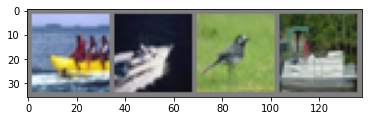

GroundTruth :  ship  ship  bird  ship 


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth : ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted : ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(4)))

Predicted :  ship  ship  bird  cat  


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images : {100 * correct // total} %')

Accuracy of the network on the 10000 test images : 53 %


In [13]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname : 0 for classname in classes}
total_pred = {classname : 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class : {classname:5s} is {accuracy:.1f} %')

Accuracy for class : plane is 59.9 %
Accuracy for class : car   is 79.3 %
Accuracy for class : bird  is 28.9 %
Accuracy for class : cat   is 44.1 %
Accuracy for class : deer  is 33.2 %
Accuracy for class : dog   is 33.1 %
Accuracy for class : frog  is 75.9 %
Accuracy for class : horse is 59.4 %
Accuracy for class : ship  is 58.9 %
Accuracy for class : truck is 66.4 %
